# Removing particles from the simulation

This tutorial shows the differnet ways to remove particles from a REBOUND simulation. Let us start by setting up a simple simulation with 10 bodies, and have the simulation assign them unique hashes so we can keep track of them (see [UniquelyIdentifyingParticles.ipynb](UniquelyIdentifyingParticles.ipynb)).

In [11]:
import rebound
import numpy as np

sim = rebound.Simulation()
sim.add(m=1.)
sim.particles[0].hash = sim.generate_unique_hash()
for i in range(1,10):
    sim.add(a=i)
    sim.particles[i].hash = sim.generate_unique_hash()
sim.move_to_com()

print("Particle hashes:{0}".format([sim.particles[i].hash for i in range(sim.N)]))

Particle hashes:[30043L, 30044L, 30045L, 30046L, 30047L, 30048L, 30049L, 30050L, 30051L, 30052L]


Let us add one more partile, this time with a custom name:

In [12]:
sim.add(a=10, hash="Saturn")
print("Particle hashes:{0}".format([sim.particles[i].hash for i in range(sim.N)]))

Particle hashes:[30043L, 30044L, 30045L, 30046L, 30047L, 30048L, 30049L, 30050L, 30051L, 30052L, 4066125545L]


Now let us run perform a short integration to isolate the particles that interest us for a longer simulation:

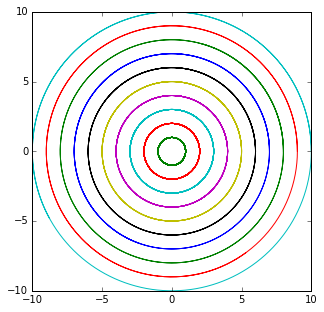

In [13]:
Noutputs = 1000
xs = np.zeros((sim.N, Noutputs))
ys = np.zeros((sim.N, Noutputs))
times = np.linspace(0.,50*2.*np.pi, Noutputs, endpoint=False)
for i, time in enumerate(times):
    sim.integrate(time)
    xs[:,i] = [sim.particles[j].x for j in range(sim.N)]
    ys[:,i] = [sim.particles[j].y for j in range(sim.N)]
%matplotlib inline
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(15,5))
for i in range(sim.N):
    plt.plot(xs[i,:], ys[i,:])
ax.set_aspect('equal')

At this stage, we might be interested in particles that remained within some semimajor axis range, particles that were in resonance with a particular planet, etc.  Let's imagine a simple (albeit arbitrary) case where we only want to keep particles that had $x < 0$ at the end of the preliminary integration. Let's first print out the particle hashes and x positions.

In [14]:
print("Hash\tx")
for i in range(sim.N):
    print("{0}\t{1}".format(sim.particles[i].hash, xs[i,-1]))

Hash	x
30043	0.0
30044	0.951056516293
30045	-1.07173995366
30046	-2.27653518091
30047	0.15703926304
30048	-4.89715510959
30049	-4.82439454094
30050	-2.2862837235
30051	2.11103373128
30052	5.29006727063
4066125545	-8.77642139671


Note that 4066125545 is the hash corresponding to the string "Saturn" we added above.  We can use the `remove()` function to filter out particlse. As an argument, we pass the corresponding index in the particles array.

In [15]:
for i in reversed(range(1,sim.N)):
    if xs[i,-1] > 0:
        sim.remove(i)
print("Number of particles after cut = {0}".format(sim.N))
print("Hashes of remaining particles = {0}".format([p.hash for p in sim.particles]))

Number of particles after cut = 7
Hashes of remaining particles = [30043L, 30045L, 30046L, 30048L, 30049L, 30050L, 4066125545L]


By default, the `remove()` function removes the `i`-th particle from the `particles` array, and shifts all particles with higher indices down by 1.  This ensures that the original order in the `particles` array is preserved. Note that this is helpful for example if you use an integrator such as WHFast which uses Jacobi coordinates.

By running through the planets in reverse order, we are guaranteed that when a particle with index `i` gets removed, the particle replacing it doesn't need to also be removed (we already checked it).

If you have many particles and many removals (or you don't care about the ordering), you can save the reshuffling of all particles with higher indices with the flag `keepSorted=0`:

In [16]:
sim.remove(2, keepSorted=0)
print("Number of particles after cut = {0}".format(sim.N))
print("Hashes of remaining particles = {0}".format([p.hash for p in sim.particles]))

Number of particles after cut = 6
Hashes of remaining particles = [30043L, 30045L, 4066125545L, 30048L, 30049L, 30050L]


We see that the order of the `particles` array has changed.

Because in general particles can change positions in the `particles` array, a more robust way of referring to particles (rather than through their index) is through their hash, which won't change.  You can pass `sim.remove` either the hash directly, or if you pass a string, it will be automatically converted to its corresponding hash:

In [17]:
sim.remove(hash="Saturn")
print("Number of particles after cut = {0}".format(sim.N))
print("Hashes of remaining particles = {0}".format([p.hash for p in sim.particles]))

Number of particles after cut = 5
Hashes of remaining particles = [30043L, 30045L, 30048L, 30049L, 30050L]


If you try to remove a particle with an invalid index or hash, an exception is thrown, which might be catch using the standard python syntax:

In [24]:
try:
    sim.remove(hash="Planet 9")
except RuntimeError as e:
    print("A runtime error occured: {0}".format(e))

A runtime error occured: Particle to be removed not found in simulation.  Did not remove particle.
